In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

In [2]:
import os, sys
home = os.path.expanduser("~")
sys.path.append(os.path.join(home,'github','QDMpy','src'))

import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (4,3)

import matplotlib.pyplot as plt

In [3]:
import QDMpy
QDMpy.LOG.setLevel('WARNING')

20:28:25     INFO QDMpy.<module> >> WELCOME TO QDMpy
20:28:25     INFO QDMpy.load_config >> Loading config file: C:\Users\micha\.config\QDMpy\config.ini
20:28:25     INFO QDMpy.<module> >> CUDA available: True
20:28:25     INFO QDMpy.<module> >> CUDA versions runtime: (11, 7), driver: (12, 0)


# Introduction
Paleomagnetism is a field of geology that studies the magnetic properties of rocks and sediments to reconstruct the Earth's past magnetic field. Traditional paleomagnetic measurements have been performed using classical rock magnetometers, which have limited spatial resolution and may average across the signal of multiple populations of magnetic grains. However, magnetic field imaging with the quantum diamond microscope (QDM) offers the potential to isolate the signal of individual magnetic grain populations and resolve ambiguities from bulk sample analyses.

QDMpy is an open-source Python package that provides a comprehensive set of tools for generating and analyzing QDM magnetic field maps of geologic samples. It utilizes modern computational techniques such as graphics processing unit (GPU) acceleration and spectral fitting routines to efficiently process large amounts of data and provide high-resolution magnetic field maps. QDMpy also contains easy-to-use functions for map editing and quantifying the net magnetic moment and rock magnetic properties of rock and mineral samples.

In this tutorial, we will guide you through the installation of QDMpy and provide step-by-step instructions for loading raw QDM data, processing the data, generating magnetic field maps, and analyzing the magnetic properties of your samples. We will also provide examples and visualizations to help you understand how to use QDMpy and interpret the results. By the end of this tutorial, you will have a solid understanding of how to use QDMpy for your own paleomagnetic research.

# The data format

QDM data from the QDMio system is typically stored in binary MATLAB files. These files can be read using the `scipy.io.loadmat` function, which returns a dictionary containing several variables. However, if the MATLAB file was saved using version 7.3 or later, the `mat73.loadmat` function should be used instead.

The QDM data dictionary contains several keys, including:

- `disp1` and `disp2`: the mean spectra for the left and right frequency ranges, respectively.
- `imgStack1` and `imgStack2`: the raw data of the measurement, which represent the fluorescence intensity of the NV centers.
- `imgStack3` and `imgStack4`: the raw data of the measurement for a third and fourth frequency range, if available.
- `freqList`: list of all frequency steps used in the measurement.
- `imgNumRows`, `imgNumRows`: the size of the image in pixels.
- `numFreqs`: the number of frequencies used in the measurement.

In [4]:
# from scipy.io import loadmat
# from mat73 import loadmat as loadmat73 # for matlab files with version 7.3

from QDMpy.utils import loadmat

In [5]:
QDMpy.test_data_location()

WindowsPath('D:/Dropbox/FOV18x')

In [6]:
# this is a dataset, which has been binned with bin=8. The reflected light and laser images, however are untouched.
# Be aware that binning this set with bin <=8 is not possible.
path_to_the_qdm_datafolder = QDMpy.test_data_location() 

In [7]:
pos_field = loadmat(os.path.join(path_to_the_qdm_datafolder, 'run_00000.mat'))
neg_field = loadmat(os.path.join(path_to_the_qdm_datafolder, 'run_00001.mat'))

In [8]:
pos_field.keys()

dict_keys(['__header__', '__version__', '__globals__', 'disp1', 'disp2', 'freqList', 'imgNumCols', 'imgNumRows', 'imgStack1', 'imgStack2', 'numFreqs'])

It contains several "variables". `disp1` and `disp2` are the mean spectra for the left and right frequency range respectively. 
`imgStack1` and `imgStack2` are the raw data of the measurement. 

Notes: 
- the data is normalized internally in teh QDM Labview software. 
- in the case of 101 frequencies, there are two additional variables: `imgStack3` and `imgStack4`

The other variables show the size of the image and the number of frequencies used.

# The ODMR object
The ODMR (Optically Detected Magnetic Resonance) object is a key component of QDMpy for processing QDM data. It represents the ODMR data, which is a 4D array of fluorescence intensity values measured as a function of magnetic field direction and frequency. The ODMR data format is `[polarity, f_range, n_pixels, n_freqs]`, where:

- `polarity` refers to the magnetic field polarity, positive or negative.
- `f_range` refers to the frequency range used in the measurement, either low or high.
- `n_pixels` is the number of pixels in the image.
- `n_freqs` is the number of frequency steps used in the measurement.

The ODMR object is initialized using the ODMR class, which takes in the raw QDM data as a 4D numpy array, as well as the scan dimensions and frequency steps. The ODMR object provides several methods for pre-processing the data, including normalization, binning, outlier removal, and global fluorescence correction.

The ODMR object can also be indexed to return the data of a specific polarization, frequency range, pixel, or frequency. For example, `odmr['+']` returns the data for the positive polarization, while `odmr['+', '<']` returns the data for the positive polarization and low frequency range.

In the following sections, we will show you how to use the ODMR object to pre-process and analyze your QDM data using QDMpy.

## creating an instance
### manually

If you want to create an ODMR instance manually, you can do so by directly specifying the raw QDM data, scan dimensions, and frequencies used to measure.

First, we need to prepare the data by loading it from the QDM MATLAB files using the loadmat function provided by QDMpy. For this example, we will use the binned Utrecht test data included in QDMpy:

In [9]:
from QDMpy.core import ODMR

Next, we need to format the data into a 4D numpy array with dimensions `[polarity, f_range, n_pixels, n_freqs]`. The ODMR object expects the data to be formatted in this way. We can achieve this by creating a new numpy array and swapping the frequency and pixel axes:

In [10]:
odmr_data = np.array([[pos_field['imgStack1'], pos_field['imgStack2']], [neg_field['imgStack1'], neg_field['imgStack2']]])
odmr_data = odmr_data.swapaxes(-1,-2) # swap pixel/frequency axes
odmr_data.shape

(2, 2, 36000, 51)

Lets check that this is correct. The `imgStack2` of the first file (`pos_field`) is the high frequency mesurement range and as such must be the same as index `[0,1]` in the new array. We only need to transpose the array because the QDMio file is stored as [frequency, pixel] and we want [pixel, frequency].

In [11]:
np.allclose(pos_field['imgStack2'].T, odmr_data[0,1])

True

Next, we need to extract the scan dimensions from the `imgNumRows` and `imgNumCols` variables stored in the MATLAB file:


In [12]:
scan_dimensions = tuple([pos_field['imgNumRows'][0,0], pos_field['imgNumCols'][0,0]])
scan_dimensions

(150, 240)

Finally, we need to format the frequency list. In this example, all frequencies are saved in a single long array, so we split it into two frequency ranges:

In [13]:
frequencies = np.array([pos_field['freqList'][0,:51], pos_field['freqList'][0,51:]])
frequencies.shape

(2, 51)

Now we can create a new instance of the ODMR object using the formatted data:

In [14]:
odmr_manual = ODMR(data_array=odmr_data, scan_dimensions=scan_dimensions, frequency_array=frequencies)

While this worked fine, when larger fields are applied, the data files have two additional variables `imgStack3` and `imgStack4` due to the larger data (at least in the current version 2022 of the QDM software). This makes the manual creation is more complicated.

Luckily, QDMpy has a more simple option to do all of the above in one line of code.

### Creating an ODMR Instance Automatically

QDMpy provides a simple method for automatically creating an ODMR instance from QDMio data using the `from_qdmio` method of the ODMR class. This method will automatically read in and format the data from two `run_*.mat` files in the specified folder.

In [15]:
odmr_inst = ODMR.from_qdmio(path_to_the_qdm_datafolder)

Note that the `path_to_the_qdm_datafolder` should be the path to the folder containing the QDMio files. If the folder does not contain the correct files or the files are formatted incorrectly, the `from_qdmio` method will raise an exception.

We can check that the automatic instance creation is correct by comparing the data of the `odmr_manual` instance created manually and the `odmr_inst` instance created automatically:

In [16]:
np.allclose(odmr_manual.data, odmr_inst.data)

True

Since the data is the same, we can proceed with processing and analyzing the ODMR data using the functions provided by QDMpy.

## Accessing the data
The ODMR instance contains the ODMR data in the `data` attribute. The data is organized in a four-dimensional array with the shape `[polarity, f_range, n_pixels, n_freqs]`. To access the data of a specific polarization, frequency range, pixel or frequency, you can use the `__getitem__` method and pass in the desired return value as an argument.

In [17]:
# access the data of the first pixel in the positive polarization and low frequency range
odmr_inst['+', '<'];

In [18]:
# get the low frequency data (left side of the spectrum)
odmr_inst['<']
# get the high frequency data
odmr_inst['>']
# get the positive field data
odmr_inst['+']
# get the negrative field data
odmr_inst['-'];

All these can be combined to yield the positive low frequency data, for instance.

In [19]:
odmr_inst['<+'];

If you check the data shape, here all pixels are stored row by row in a long array.

In [20]:
odmr_inst['<+'].shape

(36000, 51)

This makes it harder to get the data of the pixel at x = 42, and y = 99 for example. So you can use `'r'` to get the data reshaped into a 2D array.

Now finding the pixel is easy (Note: x = col, y = row and numpy uses [row, col] which can be confusing)

Text(0.5, 0, 'f [GHz]')

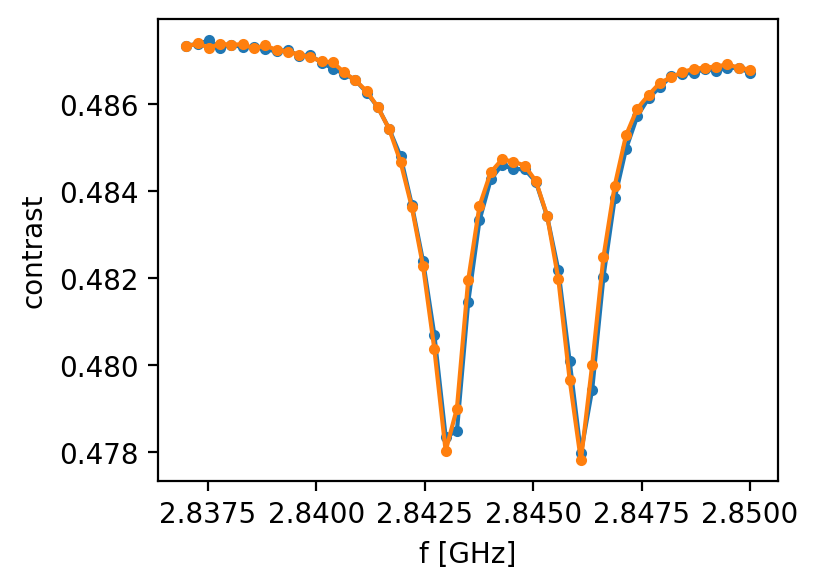

In [21]:
plt.plot(odmr_inst.f_ghz[0], odmr_inst['<+r'][99,42], '.-')
plt.plot(odmr_inst.f_ghz[0], odmr_inst['<-r'][99,42], '.-')
plt.ylabel('contrast')
plt.xlabel('f [GHz]')

In [22]:
# make a copy of the data for further processing
data_copy = odmr_inst.data.copy()

Note that the `__getitem__` method returns a view of the data, not a copy. If you modify the view, the original data will also be modified. If you want to make a copy of the data, you can use the copy method.

#### advanced indexing
Obviously you can access te data in `ODMR.data` like any other numpy array, and as we just saw you can index the ODMR object using `'<>+-r'` but you can also use `rc2idx` and `idx2rc` to get the index from row and column values and viceversa.

In teh example above, x = 42 and y = 99 have r = 99 and c = 42. Lets find the index of the corresponding pixel.


In [23]:
idx = odmr_inst.rc2idx((99,42))
idx

23802

This will give you the exact same plot as above.

Text(0.5, 0, 'f [GHz]')

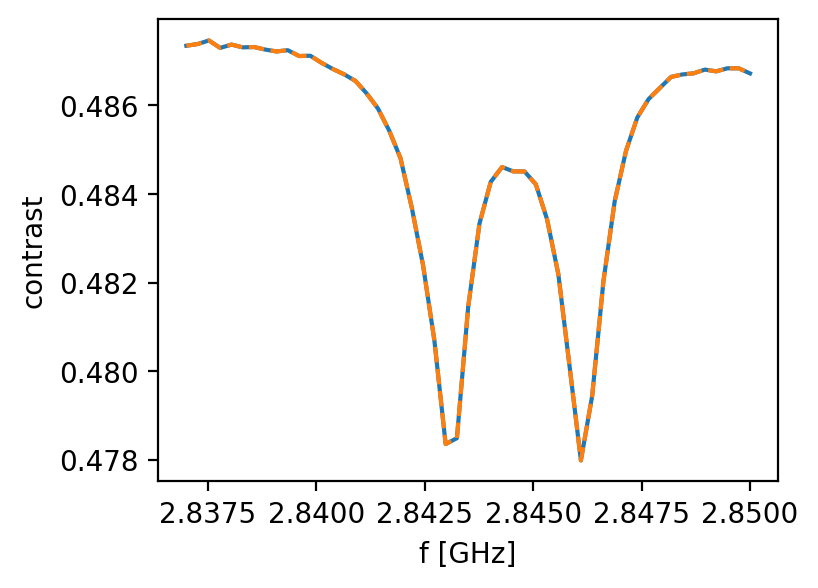

In [24]:
plt.plot(odmr_inst.f_ghz[0], odmr_inst['<+'][idx])
plt.plot(odmr_inst.f_ghz[0], odmr_inst['<+r'][99,42], ls='--')

plt.ylabel('contrast')
plt.xlabel('f [GHz]')

Similarly, the method `idx2rc` does the opposite and shour return our x = 42 and y = 99.

In [25]:
odmr_inst.idx2rc(idx)

(array([99], dtype=int64), array([42], dtype=int64))

## Data manipulation
### data binning

In most cases, we use binning to get better signal-to-noise ratio. This also reduces the filesize and all calculations are done more quickly. However, we lose some spatial resolution doing this.

Binning the data is done with `ODMR.bin_data(bin_factor)`.

Note: the dataset 'utrecht_test_data' is already binned with `bin_factor = 8` so that it can be uploaded to the github repository.

In [26]:
odmr_inst.bin_data(bin_factor=2)

As you can see, this reduces the image from 150x240 -> 75x120. Internally we use `skimage.measure.block_reduce` with `np.nanmean` to calculate the mean of a `bin_factor x bin_factor` window.

You can also reset the binning by just binning again with `bin_factor = 1`.

In [27]:
odmr_inst.bin_data(bin_factor=1)

To see what is happening internally, lets set the logging to debug and run it again.

In [28]:
QDMpy.LOG.setLevel("DEBUG")

In [29]:
odmr_inst.bin_data(bin_factor=1)

20:28:36    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
20:28:36    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
20:28:36    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of factors: (2, 2, 36000, 1)
20:28:36    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: max
20:28:36    DEBUG QDMpy._core.odmr._bin_data >> Binning data [150 240] with factor 1 (pre bin factor: 1)
20:28:36     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x150x240x51


In [30]:
odmr_inst.bin_data(bin_factor=2)

20:28:36    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
20:28:36    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
20:28:36    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of factors: (2, 2, 36000, 1)
20:28:36    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: max
20:28:36    DEBUG QDMpy._core.odmr._bin_data >> Binning data [150 240] with factor 2 (pre bin factor: 1)
20:28:36     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x75x120x51


As you can see there is quite a lot happening 'under the hood'. Because we are manipulating the data irreversibly, I am using a what I call `edit stack`. If you make any change tho the processing, the whole stack is reapplied. While this is rather time-consuming for larger datasets, it ensures, that nothing unexpected happens to the data.
The stack (so far) is defined as follows:

0. reset the data to original (i.e. the data as it is in the file)
1. normalize the data (`ODMR.normalize_data`)
2. bin the data (`ODMR.bin_data`)
3. apply outlier mask (`apply_outlier_mask`)
4. correct global fluorescence (`correct_global_fluorescence`)

### Global fluorescence correction

ODMR daa also contains an additional signal, which stems from teh internal reflections within a diamond. We call this the global fluorescecne, in contrast to the local fluorescence at the pixel. The total signal, therefore, is `total = global + local`.  This signal is a typically a zero field signal.
We can subtract that signal by specifying the portion of the global signal to the total signal (e.g. 0.2 -> 20% of the total signal is the global fluorescence).

In [31]:
QDMpy.LOG.setLevel("INFO")

In [36]:
odmr_inst.correct_glob_fluorescence(0.2)

20:31:10     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x75x120x51
20:31:10     INFO QDMpy._core.odmr._correct_glob_fluorescence >> Correcting for global fluorescence with value 0.2
[[0.99934875 0.99925998]
 [0.99936336 0.99925206]]


If you look closely at the log, you can see that the whole `edit_stack` is again applied. This behavior is unfortunate and should if possible be changed as it takes a lot of time doing this every time.

An easy way to check the way the global_factor affects the signal and wether you have corrected enough/too much, is the `ODMR.check_blob_fluorescence` method. You can specify a new `global_factor` and it will show you a plot of the pixel, that most diverges from the mean (see: `ODMR.most_divergent_from_mean`).

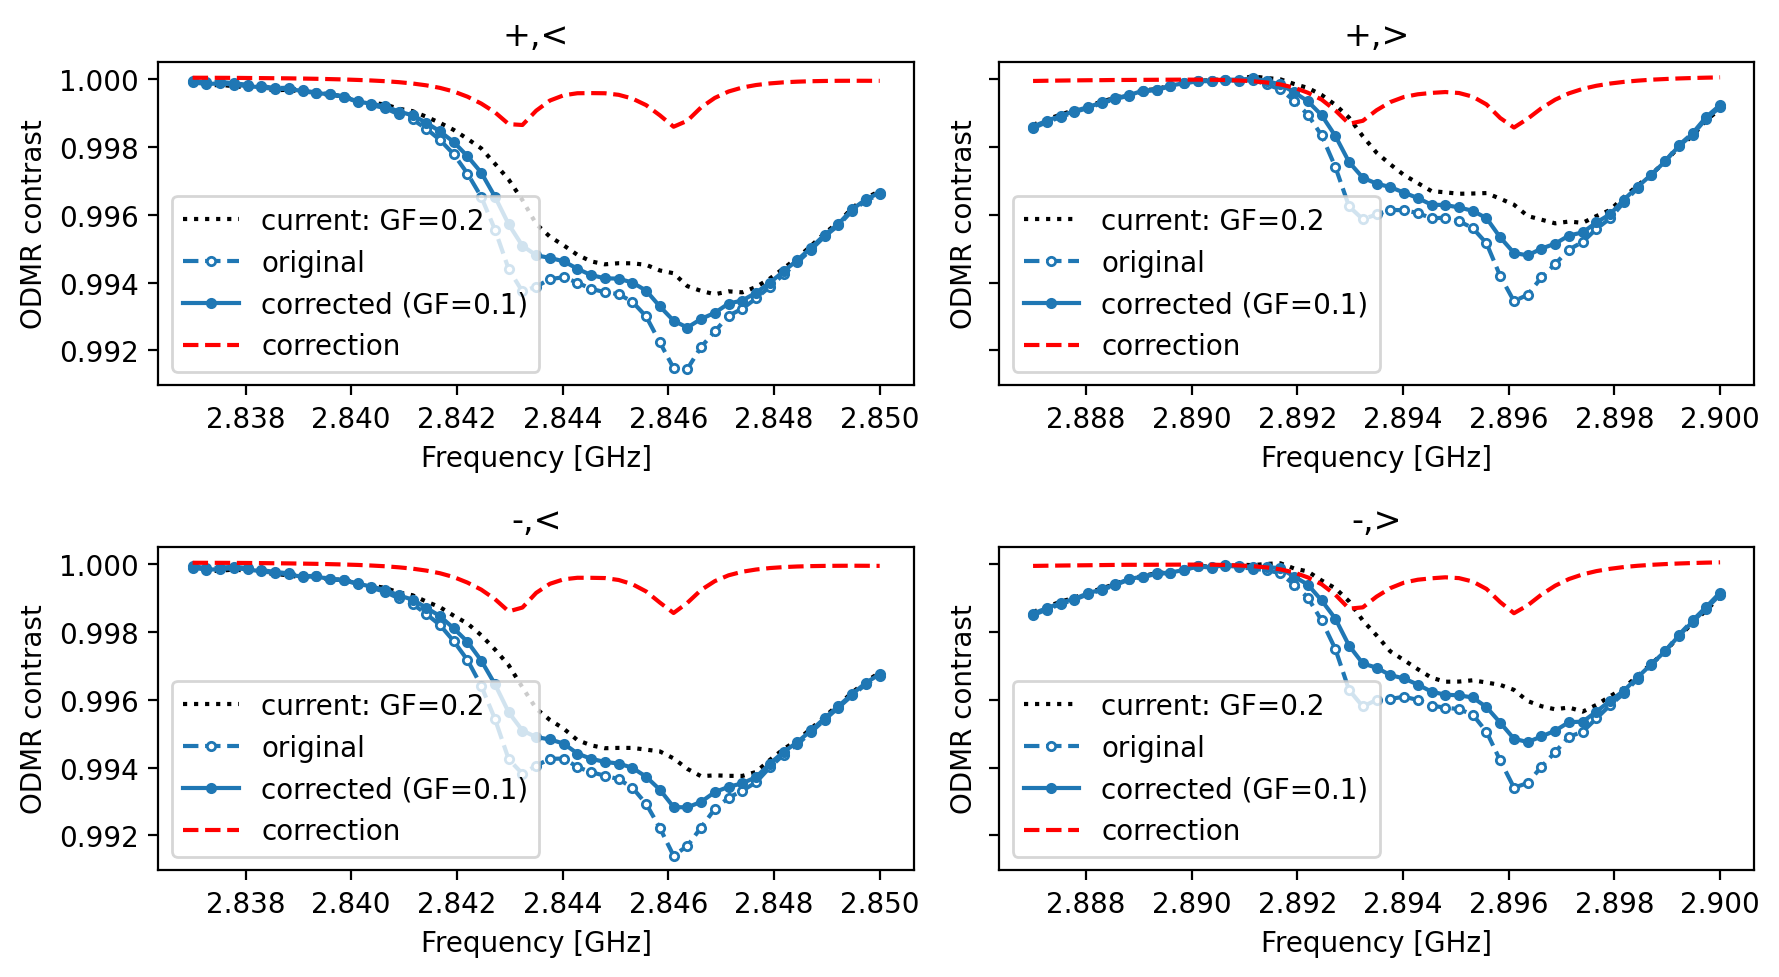

In [37]:
odmr_inst.check_glob_fluorescence(0.1)

# The Fit object

In [38]:
from QDMpy.core import Fit

The fit class is a container for the data and handles all the fitting related things. In theory you should not need to create one on your own, but lets go through it anyways.

In [39]:
fit_inst = Fit(data=odmr_inst.data, frequencies = odmr_inst.f_ghz)

20:31:44     INFO QDMpy._core.fit.guess_model_name >> Guessed diamond type: 2 peaks -> ESR15N (N15)
20:31:44     INFO QDMpy._core.fit._reset_fit >> Fit results have been reset.


Lets check if this is the same (i.e. in memory) data as in the ODMR and QDM (later) objects. 

In [40]:
id(fit_inst.data) == id(odmr_inst.data)

True

You can see that creating the object immediately tries to detect, the model needed to fit the data. The function that is called is `QDMpy._core.models.guess_model` and uses `scipy.signal.find_peaks` to detect the number of peaks in the global (mean) signal foir each frequency range / polarity/

We can check if the model is correct by calling `Fit.guess_model_name(check = True)`. However, this should not be necessary in most cases.

20:31:51     INFO QDMpy._core.fit.guess_model_name >> Guessed diamond type: 2 peaks -> ESR15N (N15)


'ESR15N'

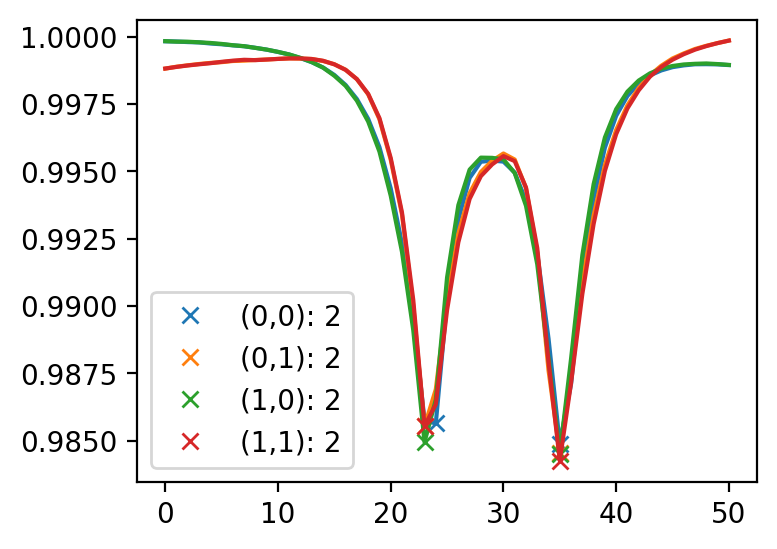

In [41]:
fit_inst.guess_model_name(check=True)

The plot shows the mean spectra (i.e. mean of all pixels) for all 4 measurement sweeps (+/- B, high/low frange). `scipy.signal.detect_peaks` determines how many peaks are in the signal. A N14 diamond should have 3 per sweep, a N15 diamond only 2 and bombarded diamonds usually only have a single peak. 

This works well in most cases, but sometimes the data is of very bad quality and as such QDMpy can fail to detect the correct model. In this case, a warning message will be displayed and you can set the model manually.

In [42]:
fit_inst.model_name = 'ESR14N'

20:31:55     INFO QDMpy._core.fit.model_name >> Setting model to ESR14N, resetting all fit results and initial parameters.
20:31:55     INFO QDMpy._core.fit._reset_fit >> Fit results have been reset.


In [44]:
%prun fit_inst._guess_center()

         9 function calls in 1.357 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.356    1.356    1.356    1.356 fit.py:950(guess_center)
        1    0.000    0.000    1.356    1.356 fit.py:595(_guess_center)
        1    0.000    0.000    1.357    1.357 {built-in method builtins.exec}
        1    0.000    0.000    1.356    1.356 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 serialize.py:29(_numba_unpickle)
        1    0.000    0.000    0.000    0.000 __init__.py:1455(debug)
        1    0.000    0.000    0.000    0.000 fit.py:77(data)
        1    0.000    0.000    0.000    0.000 __init__.py:1724(isEnabledFor)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

When setting the model manually, all initial guess parameters are reset and have to be recalcualted.

In [ ]:
fit_inst.model_name = 'ESR15N'

## initial  guesses

To get a good fit for the data, we need a good initial guess. This is crucial, since the fit will not be reliable if the initial guess is bad.

There are 3 parameters, which need to be guessed for each pixel: the center of the distributions (i.e. resonance), the width of the lorentzian distributions and the contrast (we assume the same contrast for all peaks).

In [ ]:
from QDMpy._core import fit

### center 

I am estimating the center by using a normalized cumulative sum (i.e. from 1->0) of the spectra. The center is estimated to be the frequency where y=0.5.

### width

Similar to the center frequency, a rough estimate of the width is determined by the difference of the frequencies at two values `vmin` and `vmax`. `vmin` and `vmax` are specific to the type of model (i.e. N14, N15). For instance, the values for `vmin` and `vmax` in the N15 case (here) are: 0.4 and 0.6. Meaning the difference of the frequency at y=0.4 and y=0.6 of the normalized cumsum is estimated as the width of the lorentzian distribution.

### contrast

Finally, the contrast is simply the difference between the maximum and minimum of the data.

In [ ]:
ax = plt.gca()
idx = 0
# calc the cumsum
pixel_data = odmr_inst.data[0,0,idx]
pixel = fit.normalized_cumsum_pixel(pixel_data)

# add horizontal lines for reference
plt.axhline(0.4, c='0.5', alpha=0.5, lw=0.7, ls='--')
plt.axhline(0.5, c='0.5', alpha=0.5, lw=0.7, ls='--')
plt.axhline(0.6, c='0.5', alpha=0.5, lw=0.7, ls='--')

# plot data
plt.plot(fit_inst.f_ghz[0], pixel, label='cumsum')
ax2 = ax.twinx()
ax2.plot(fit_inst.f_ghz[0], pixel_data, '.-', c='0.8', label='data')

# center
center = fit.guess_center_pixel(pixel_data, fit_inst.f_ghz[0])
idx = np.argmin(np.abs(fit_inst.f_ghz[0]-center))
plt.axvline(center, c='r', lw=0.5, alpha=0.5, label='center frequency')

# width
vmin, vmax = 0.4, 0.6
lidx = np.argmin(np.abs(pixel - vmin))
ridx = np.argmin(np.abs(pixel - vmax))
plt.axvspan(fit_inst.f_ghz[0,lidx], fit_inst.f_ghz[0,ridx], alpha=0.2, label='width') 
ax.set(xlabel = 'f [GHz]', ylabel='cumsum')
ax2.set(xlabel = 'f [GHz]', ylabel='contrast [arb. unit]')

plt.legend(loc='lower left')

You can see that the estimation isnt bad in this case. Let's have a look at a bad pixel:

In [ ]:
ax = plt.gca()
idx = odmr_inst.most_divergent_from_mean()[-1]
# calc the cumsum
pixel_data = odmr_inst.data[0,0,idx]
pixel = fit.normalized_cumsum_pixel(pixel_data)

# add horizontal lines for reference
plt.axhline(0.4, c='0.5', alpha=0.5, lw=0.7, ls='--')
plt.axhline(0.5, c='0.5', alpha=0.5, lw=0.7, ls='--')
plt.axhline(0.6, c='0.5', alpha=0.5, lw=0.7, ls='--')

# plot data
plt.plot(fit_inst.f_ghz[0], pixel, label='cumsum')
ax2 = ax.twinx()
ax2.plot(fit_inst.f_ghz[0], pixel_data, '.-', c='0.8', label='data')

# center
center = fit.guess_center_pixel(pixel_data, fit_inst.f_ghz[0])
idx = np.argmin(np.abs(fit_inst.f_ghz[0]-center))
plt.axvline(center, c='r', lw=0.5, alpha=0.5, label='center frequency')

# width
vmin, vmax = 0.4, 0.6
lidx = np.argmin(np.abs(pixel - vmin))
ridx = np.argmin(np.abs(pixel - vmax))
plt.axvspan(fit_inst.f_ghz[0,lidx], fit_inst.f_ghz[0,ridx], alpha=0.2, label='width') 
ax.set(xlabel = 'f [GHz]', ylabel='cumsum')
ax2.set(xlabel = 'f [GHz]', ylabel='contrast [arb. unit]')

plt.legend(loc='lower left')

Again, teh estimation isn't so bad, even though the width may be a little off.

## calculating the fit 
In order to do the fit calculation, call `fit_odmr` just like in the QDM object.

In [ ]:
fit_inst.fit_odmr()
default = fit_inst.get_param("center").copy()
default_chi = fit_inst.get_param("chi").copy()

This determines the best fit [center, width, contrast and offset] for each pixel using the default fitting constraints (see e.g. `/home/YOU/.config/QDMpy/config.ini`). To show the used constraints, you can use:

In [ ]:
fit_inst.constraints

### constraints

Each entry in the dict is composed of [lower bound, upper bound, bound type, unit]. If these do not give usable results, you can set them to something better.

Note: this will not change the default values, edit the config.ini file to do that.

In [ ]:
fit_inst.set_constraints('width', 1e-6, 3e-6, 'LOWER_UPPER')

Because this rest the calculated fit, we need to recalculate it.

In [ ]:
fit_inst.fit_odmr()
change = fit_inst.get_param("center").copy()
change_chi = fit_inst.get_param("chi").copy()

### free constraints 
In some cases, it may be better to not constrain the fit. To do this, call:

In [ ]:
fit_inst.set_free_constraints()

Again, the fit needs to be recalculated if we change the constraints.

In [ ]:
fit_inst.fit_odmr()
free = fit_inst.get_param("center").copy()
free_chi = fit_inst.get_param("chi").copy()

Lets see if there is a big difference. First the resonance:

In [ ]:
from QDMpy import plotting

In [ ]:
f, ax = plt.subplots(1,3, figsize = (15,4), sharex=False, sharey=False)

norm_percentile = (0,100) # colorscaling
im = plotting.plot_data(ax=ax[0], data=default.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[0], im, label='f [GHz]')
im = plotting.plot_data(ax=ax[1], data=change.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[1], im, label='f [GHz]')
im = plotting.plot_data(ax=ax[2], data=free.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[2], im, label='f [GHz]')

for i, a in enumerate(ax.flat):
    a.set(xlabel='', ylabel='', title=['default', 'changed', 'free'][i])
plt.tight_layout()

Here the change between the free and constrained fit is small. However, other maps (especially strong ones), the differences between constraints may be more pronounced. On the other hand, changing the constraint of the width, removes a lot of the signal in teh lower left and right og the figure. If this is "good" has to be decided by checking the data the fit for these pixels.

Looking at the misfit, shows that the changed width constraint does give worse results than the default (i.e. higher X2).

In [ ]:
f, ax = plt.subplots(1,3, figsize = (15,4), sharex=False, sharey=False)
# ax = ax.flatten()
im = plotting.plot_data(ax=ax[0], data=default_chi.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[0], im, label='$\chi^2$')
im = plotting.plot_data(ax=ax[1], data=change_chi.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[1], im, label='$\chi^2$')
im = plotting.plot_data(ax=ax[2], data=free_chi.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[2], im, label='$\chi^2$')

for i, a in enumerate(ax.flat):
    a.set(xlabel='', ylabel='', title=['default', 'changed', 'free'][i])
plt.tight_layout()

# QDM object

The QDM object is a container to handle the above computations (ODMR, fit) and calculate the magnetic fields from the data of the fit (i.e. resonance frequencies).

In [ ]:
from QDMpy.core import QDM

In order to bypass the creation of an ODMR and Fit object, you can create a new instance of `QDM` using the `QDM.from_qdmio` method, justy like before. Pass the folder with the data and the instance is created automatically. However, in contrast to the ODMR object, the folder also needs to contain a `LASER.csv` and `LED.csv` (`.jpg` work too but csv is preferred). 

In [ ]:
qdm_inst = QDM.from_qdmio(data_folder=path_to_the_qdm_datafolder)

If you look at the log, you can see that we create an `ODMR` object first, pass the data to create a `Fit` object and then create the `QDM` object. You can access the instances and all their methods with:

In [ ]:
# the ODMR object instance
type(qdm_inst.odmr)

In [ ]:
# the Fit object instance
type(qdm_inst.fit)

## Data manipulation
### Binning (again)
As mentioned before, the test data is already binned with `bin_factor = 8`. Therefore, binning to anything lower than 8 is not possible. The images (LASER, LED) on the other hand have not been topuched, which means that the data size does not correspond with the image siz and has to be dealt with internally (see: `pre_binfactor`).

Internally, `QDM.bin_data` is just a wrapper around the `ODMR.bin_data` method and as such should behave just the same (with the exception of the pre_binning, needed for datasets, where `img_size != data_size`).

In [ ]:
qdm_inst.bin_data(8) # anything with bin_factor < 8 will raise an error

Just like `bin_data`, `QDM.correct_glob_fluorescence` is a wrapper of `ODMR.correct_glob_fluorescence` and behaves in very much the same way.

In [ ]:
qdm_inst.correct_glob_fluorescence(0.2)

## fitting
Fitting the data is obviously the main goal. The `Fit` objects handles all that and the most important methods are wrapped in the `QDM` onject. So you can simply call `QDM.fit_odmr()` and dont need to write `QDM.fit.fit_odmr()`.

In [ ]:
qdm_inst.fit_odmr()

Also changing the fit restraints is wrapped and you can use `QDM.set_constraints` to change them. Remember, this resets the fit.

In [ ]:
qdm_inst.set_constraints('width', 1e-4, 1e-5)

In [ ]:
qdm_inst.fit_odmr()

In [ ]:
qdm_inst.set_constraints('width', None, None, 'FREE')
qdm_inst.fit_odmr()

## Results

The results of the fit are contained in tehrh `Fit` object. To access them from teh QDM instance, you can use `QDM.get_param` with one of the following parameters:

1. resonance
2. width
3. contrast
    1. `contrast` gives contrast for all peaks
    1. `contrast_n` gives specific contrast for peak n
    2. `mean_contrast` if you want the mean contrast
4. chi2 for chi squared of the fits
5. states of the fit (i.e. if it failed or not)
6. num: number of iterations to fit

By default it resurns the data in  the correct "image shape" but you can specify `reshape = False` to get the original shape.

In [ ]:
'reshaped:', qdm_inst.get_param('num').shape, 'original shape:', qdm_inst.get_param('num', reshape=False).shape

The `contrast_n` has an extra dimension with [npeak, pol, frange, y, x]. So that `qdm_inst.get_param('contrast')[0,1,0,99,42]` will return the contrast of the first peak in the second polarity of the lower field range of pixel (42,99).

In [ ]:
qdm_inst.get_param('contrast').shape, 'or not reshapes:', qdm_inst.get_param('contrast', reshape=False).shape

## BUG

In [ ]:
c = qdm_inst.get_param('contrast', reshape=False)
c_ = qdm_inst.get_param('contrast')

In [ ]:
c[0,0,0,1], c_[:,:,:,0,0] 

In [ ]:
qdm_inst.plot(remanence=False, norm_percentile=(0.5,99.5), scalebar=10e-6)

In [ ]:
from QDMpy._core.convert import project, b111_to_bxyz

In [ ]:
b111 = qdm_inst.b111_remanent

In [ ]:
bz = project(np.stack([b111.reshape(-1),b111.reshape(-1),b111.reshape(-1)]).T, [0,0,1])

In [ ]:
f, ax = plt.subplots(1,3, figsize = (12,4), sharex=False, sharey=False)
# ax = ax.flatten()
plotting.plot_data(data=qdm_inst.b111_remanent, ax=ax[0], norm_percentile=(0.5,99.5))
plotting.plot_data(data=bz.reshape(qdm_inst.b111_remanent.shape), ax=ax[1], norm_percentile=(0.5,99.5))
plotting.plot_data(data=b111_to_bxyz(qdm_inst.b111_remanent)[2], ax=ax[2], norm_percentile=(0.5,99.5))

In [ ]:
np.linalg.norm([1,2,3]), np.linalg.norm([3.74,0,0]),

# Some additional thoughts 

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/Users/mike/github/QDMpy/src')

from QDMpy._core.models import esr15n, esr15n_folded

def secondary(fsec):
    f = np.linspace(2.8,2.9, 1000)
    plt.plot(f, esr15n(f, [2.87, 0.001, 0.1, 0.1, 0]), '--', lw=0.5)
    plt.plot(f, esr15n(f-fsec/1000, [2.87, 0.001, 0.1, 0.1, 0]),'--', lw=0.5)
    
    plt.plot(f, esr15n_folded(f, [2.87, 0.001, 0.1, 0.1, 0, fsec/1000]))
    plt.ylim(0.7,1)
interact(secondary, fsec=widgets.FloatSlider(min=0, max=5, step=0.02, value=0));



In [ ]:
sys.path